In [1]:
import os, sys
# HOME = os.environ['HOME']  # change if necessary
HOME = '/workspace/wilson'
sys.path.append(f'{HOME}/Finite-groups/src')
# from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
# from model_utils import *
from train import Parameters
%load_ext autoreload
%autoreload 2

from flax import linen as nn, struct
from flax.training.train_state import TrainState
from jax.flatten_util import ravel_pytree
from optax import (
    softmax_cross_entropy_with_integer_labels as xent
)
import jax
import jax.numpy as jnp
import optax
from jaxtyping import Int, Array, Float
from functools import partial
from dataclasses import dataclass
from frozendict import frozendict

In [2]:
class MLP2(nn.Module):
    # right now this hardcodes a lot of things to the defaults
    cfg: frozendict
    N: int

    @nn.compact
    def __call__(self, a: Int[Array, 'batch entry']) -> Float[Array, 'batch vocab']:
        a1, a2 = a[...,0], a[...,1]
        embedding_init = nn.initializers.normal(stddev=1.0)
        # In the torch code, uniform bounds are \pm 1/sqrt(fan_in) * 1/sqrt(2) (kaiming_uniform with scale=1/sqrt(2) to account for 2 input arguments)
        # This corresponds to std = 1/sqrt(6) * 1/sqrt(fan_in)
        # variance_scaling sets std = sqrt(scale) / sqrt(fan_in)
        # So we should set scale = 1/6 to get the same initialization
        kernel_init = nn.initializers.variance_scaling(mode='fan_in', distribution='uniform', scale=1/6)
        # This differs from the pytorch version
        # In pytorch we had uniform distribution over [-1/sqrt(fan_in), 1/sqrt(fan_in)]
        # Here we use constant initialization to 1/N
        # The former matches the default for torch.nn.Linear, but it doesn't seem motivated by anything
        # and anyways I don't know how to recreate it with flax...
        bias_init = nn.initializers.constant(1 / self.N)
        # bias_init = nn.initializers.uniform(scale=1/np.sqrt(self.params.hidden_size))
        x1 = nn.Embed(self.N, self.cfg['embed_dim'], embedding_init=embedding_init, name='embedding_left')(a1)
        x2 = nn.Embed(self.N, self.cfg['embed_dim'], embedding_init=embedding_init, name='embedding_right')(a2)
        h1 = nn.Dense(self.cfg['hidden_size'], use_bias=False, kernel_init=kernel_init, name='linear_left')(x1)
        h2 = nn.Dense(self.cfg['hidden_size'], use_bias=False, kernel_init=kernel_init, name='linear_right')(x2)
        h = h1 + h2
        act = nn.relu(h)
        return nn.Dense(self.N, kernel_init=kernel_init, bias_init=bias_init, name='unembedding')(act)


In [3]:
def make_apply_full(model, unraveler):
    """Apply function that takes raveled params vector."""
    def apply_full(raveled, x):
        params = unraveler(raveled)
        return model.apply(params, x)
    
    return apply_full

def loss_fn(params, apply_fn, x, z):
    logits = apply_fn(params, x)
    preds = jnp.argmax(logits, axis=-1)
    loss = xent(logits, z).mean()
    acc = (preds == z).mean()
    return loss, acc

def wd_loss_fn(params, apply_fn, x, z, wd):
    loss, acc = loss_fn(params, apply_fn, x, z)
    return loss + wd / 2 * jnp.linalg.norm(params) ** 2, (loss, acc)

In [14]:
@partial(jax.jit, static_argnums=(3, 4))
def train(ravel_params, x, z, apply_fn, cfg: frozendict):
    tx = optax.adam(
        learning_rate=cfg['lr'],
        b1=cfg['beta1'],
        b2=cfg['beta2'],
    )
    
    state = TrainState.create(apply_fn=apply_fn, params=ravel_params, tx=tx)
    loss_and_grad = jax.value_and_grad(wd_loss_fn, has_aux=True)
    
    # TODO: support batching (right now only full batch)
    def epoch_step(state:TrainState, epoch) -> tuple[TrainState, tuple[jnp.ndarray, jnp.ndarray]]:
        jax.debug.breakpoint()
        (_, (loss, acc)), grads = loss_and_grad(state.params, state.apply_fn, x, z, cfg['weight_decay'])
        return state.apply_gradients(grads=grads), (loss, acc)

    state, (train_loss, train_acc) = jax.lax.scan(epoch_step, state, jnp.arange(cfg['epochs']))
    return state.params, (train_loss, train_acc)
        

In [15]:
device = jax.devices('gpu')[0]

PARAMS = Parameters(
    instances=1,
    # embed_dim=32,
    # hidden_size=32,
    # group_string='S(4)',
    embed_dim=32,
    hidden_size=32,
    group_string='S(4)',
    model='MLP2',
    unembed_bias=True,
    weight_decay=2e-4,
    train_frac=0.6,
    epochs=40,
)

t.manual_seed(PARAMS.seed)
np.random.seed(PARAMS.seed)
random.seed(PARAMS.seed)

group_dataset = GroupData(params=PARAMS)
train_data = jnp.array(group_dataset.train_data, device=device)

# Needs to be hashable for jax jit
CFG = frozendict(
    {k: v for k, v in PARAMS.__dict__.items() if k not in ['delta_frac']}
)


Intersection size: 576/576 (1.00)
Added 576 elements from intersection
Added 0 elements from group 0: S(4)
Taking random subset: 345/576 (0.60)
Train set size: 345/576 (0.60)


In [18]:
@jax.custom_jvp
def print_grad(x):
    return x

@print_grad.defjvp
def print_grad_jvp(primals, tangents):
    x, = primals
    t, = tangents
    jax.debug.print(t)
    return x, t

In [16]:
x_train, z_train = train_data[:,:2], train_data[:,2]
model = MLP2(CFG, group_dataset.N)
init_params = model.init(jax.random.key(PARAMS.seed), x_train)
init_ravel_params, unraveler = ravel_pytree(init_params)
apply_fn = make_apply_full(model, unraveler)

In [89]:
final_ravel_params, (train_loss, train_acc) = train(init_ravel_params, x_train, z_train, apply_fn, CFG)
train_loss[-1], train_acc[-1]

(Array(0.00673234, dtype=float32), Array(1., dtype=float32))

In [90]:
x_test = jnp.asarray(list(product(range(group_dataset.N), repeat=2)), device=device)
z_test = einops.rearrange(jnp.asarray(group_dataset.groups[0].cayley_table, device=device), 'i j -> (i j)')
loss_fn(final_ravel_params, apply_fn, x_test, z_test)

(Array(0.01418004, dtype=float32), Array(1., dtype=float32))

In [17]:
jac, _ = jax.jit(jax.jacfwd(train, has_aux=True), static_argnums=(3, 4,))(init_ravel_params, x_train, z_train, apply_fn, CFG)

Entering jdb:
> /tmp/ipykernel_5192/1618286220.py(14)
        def epoch_step(state:TrainState, epoch) -> tuple[TrainState, tuple[jnp.ndarray, jnp.ndarray]]:
->          jax.debug.breakpoint()
            (_, (loss, acc)), grads = loss_and_grad(state.params, state.apply_fn, x, z, cfg['weight_decay'])
            return state.apply_gradients(grads=grads), (loss, acc)
    
Array([-1.2874033 ,  0.28143784,  0.8255087 , ..., -0.11058992,
        0.06451517, -0.04018393], dtype=float32)
['T', '__abs__', '__abstractmethods__', '__add__', '__and__', '__annotations__', '__array__', '__array_module__', '__array_namespace__', '__array_priority__', '__bool__', '__class__', '__complex__', '__copy__', '__cuda_array_interface__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__div__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__hex__', '__

ERROR:2025-01-03 18:00:32,338:jax._src.debugging:95: jax.debug.callback failed
Traceback (most recent call last):
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/debugging.py", line 93, in debug_callback_impl
    callback(*args)
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/debugging.py", line 278, in _flat_callback
    callback(*args, **kwargs)
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/debugger/core.py", line 220, in _breakpoint_callback
    debugger(frames, thread_id, **kwargs)
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/debugger/cli_debugger.py", line 167, in run_debugger
    CliDebugger(frames, thread_id, **kwargs).run()
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/j

XlaRuntimeError: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_5192/3101063958.py", line 1, in <module>
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/pjit.py", line 337, in cache_miss
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/pjit.py", line 195, in _python_pjit_helper
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/pjit.py", line 1695, in _pjit_call_impl_python
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/profiler.py", line 333, in wrapper
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/interpreters/pxla.py", line 1289, in __call__
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py", line 2854, in _wrapped_callback
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/debugging.py", line 160, in _callback
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/debugging.py", line 96, in debug_callback_impl
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/debugging.py", line 278, in _flat_callback
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/debugger/core.py", line 220, in _breakpoint_callback
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/debugger/cli_debugger.py", line 167, in run_debugger
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/debugger/cli_debugger.py", line 162, in run
  File "/usr/lib/python3.11/cmd.py", line 145, in cmdloop
  File "/usr/lib/python3.11/cmd.py", line 217, in onecmd
  File "/root/.cache/pypoetry/virtualenvs/group_addition-jQUm9okg-py3.11/lib/python3.11/site-packages/jax/_src/debugger/cli_debugger.py", line 146, in do_quit
SystemExit: 0

In [92]:
# jnp.save('/workspace/wilson/Finite-groups/data/trainjac_S4_d32_wd2e-4_epochs4000.npy', jac)

In [10]:
U, S, V = jnp.linalg.svd(jac)

In [11]:
jac

Array([[ 1.24153781e+00, -2.41985898e-02, -2.86421329e-02, ...,
         5.69535136e-01, -1.68168306e-01, -3.25382531e-01],
       [-5.56496195e-02,  1.23230386e+00, -1.26619190e-02, ...,
        -7.53797442e-02,  6.09494895e-02, -1.22233585e-01],
       [ 7.86120072e-04, -2.45532184e-03,  9.25185263e-01, ...,
         1.32018209e-01, -6.07045479e-02, -6.15150854e-02],
       ...,
       [ 3.82915419e-03,  1.98691938e-04,  4.59734118e-03, ...,
         1.25064576e+00, -3.88171412e-02, -8.41931552e-02],
       [-3.30780633e-03,  4.11449652e-03,  1.80723204e-03, ...,
        -3.29198718e-01,  1.64218712e+00, -2.47553065e-02],
       [ 2.17470410e-03,  2.63520679e-03,  2.64763075e-05, ...,
        -7.36904657e-03,  1.31536603e-01,  9.56390858e-01]],      dtype=float32)

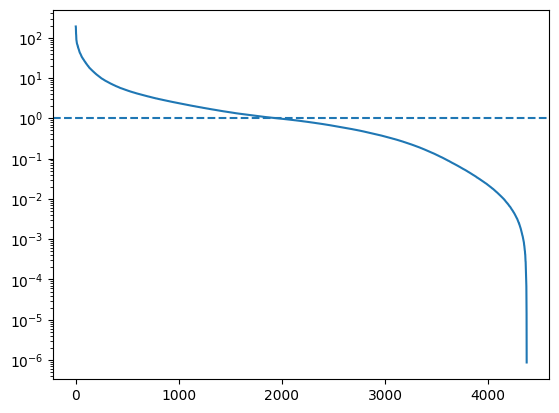

In [12]:
plt.plot(S)
plt.axhline(1, linestyle='--')
plt.yscale('log')
plt.show()